# Setup - defining parameters that probably don't change

In [31]:

#user defined parameters

#thresholds for spot detection (*std)
sigma1=50   #threshold for finding spots
sigma2=15   #threshold for calculating moments

#other spot detection parameters - probably won't need to change
boxFind=10   #box size for finding spots
boxCent=6   #box size for centroiding
nmin=10     #minimum acceptable # of pixels in spot
nmax=90     #maximum acceptable # of pixels in spot
maxIt=20    #maximum # interations for centroiding

#set to non zero to override automatic fwhm determination
fwhmx=0
fwhmy=0

#inter = 1 for notebook, 0 for scripts (displaying plots)
inter=1

#cenFlag='local' to run from local disk, 'db' to read from database
cenFlag='local'
#cenFlag='db'

#dataSource = 'pinhole'
dataType='pinhole'

#configuration for rotator center

config="oct18"
#config="aug19"
#config=None



#database info - update as needed
user='pfs'
passwd='fps'
host='133.40.164.208'
dbname='pfspass'
conn=None


# Setup - importing

In [24]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sigmaclip
import sys
from importlib import reload  #for debugging purposes

#kludge - need to change???
sys.path.append("/Users/karr/Science/PFS/NewCode/Code/pfs_utils/python/pfs/utils/coordinates/")
import CoordTransp
import DistortionCoefficients

#the try/except is for using in the MHS environment, or standalone. 


try:
    import mcsActor.Visualization.mcsRoutines as mcs
except:
    import mcsRoutines as mcs

try:
    import mcsActor.Visualization.fpsRoutines as fps
except:
    import fpsRoutines as fps

try:
    import mcsActor.Visualization.visRoutines as vis
except:
    import visRoutines as vis



# setup - connect to database, load instrument parameters

In [25]:

reload(vis)
#connect to database if in DB mode
if(cenFlag=='db'):
    conn=vis.dbConnect(user=user,dbname=dbname,passwd=pfspass,host=host)
    
#read instrument parameters if available
if(config != "calib"):
    rotCent,offset=vis.loadInstParams(config)


# setup - parameters that change for each run

In [26]:

#set frame ID minimum and maximum values (inclusive)

frameId1=2498
frameId2=2508

#a list of any frames to skip (bad data, etc). Can be empty.
frameSkip=[]   

za=0

#source directory data files in local mode
sourceDir="/Volumes/Vaal/Commissioning Run/2018-10-24/"

#subtitle for plots - currently set to first frame ID plus tag
stitle=" ["+str(frameId1).zfill(6)+"]"

fPref="PFSC"
#get various file name inforamtion
files,prefix,centroidFile,frameIDs=vis.getFileNames(frameId1,frameId2,frameSkip,sourceDir,fPref,dataType)

nfiles=len(files)
print("Read "+str(len(files))+" files names. First = "+str(frameId1)+" Last="+str(frameId2))
print("prefix="+prefix+" centroidFile="+centroidFile)


Read 11 files names. First = 2498 Last=2508
prefix=see_02498_02508 centroidFile=see_02498_02508_centroids.dat


# calculate threshold values and region (once per config)

Thresholds= 1843.855619174775 1142.6118278292856
Boundaries of region (x1,x2,y1,y2):  1126 5060 3684 7601


<IPython.core.display.Javascript object>


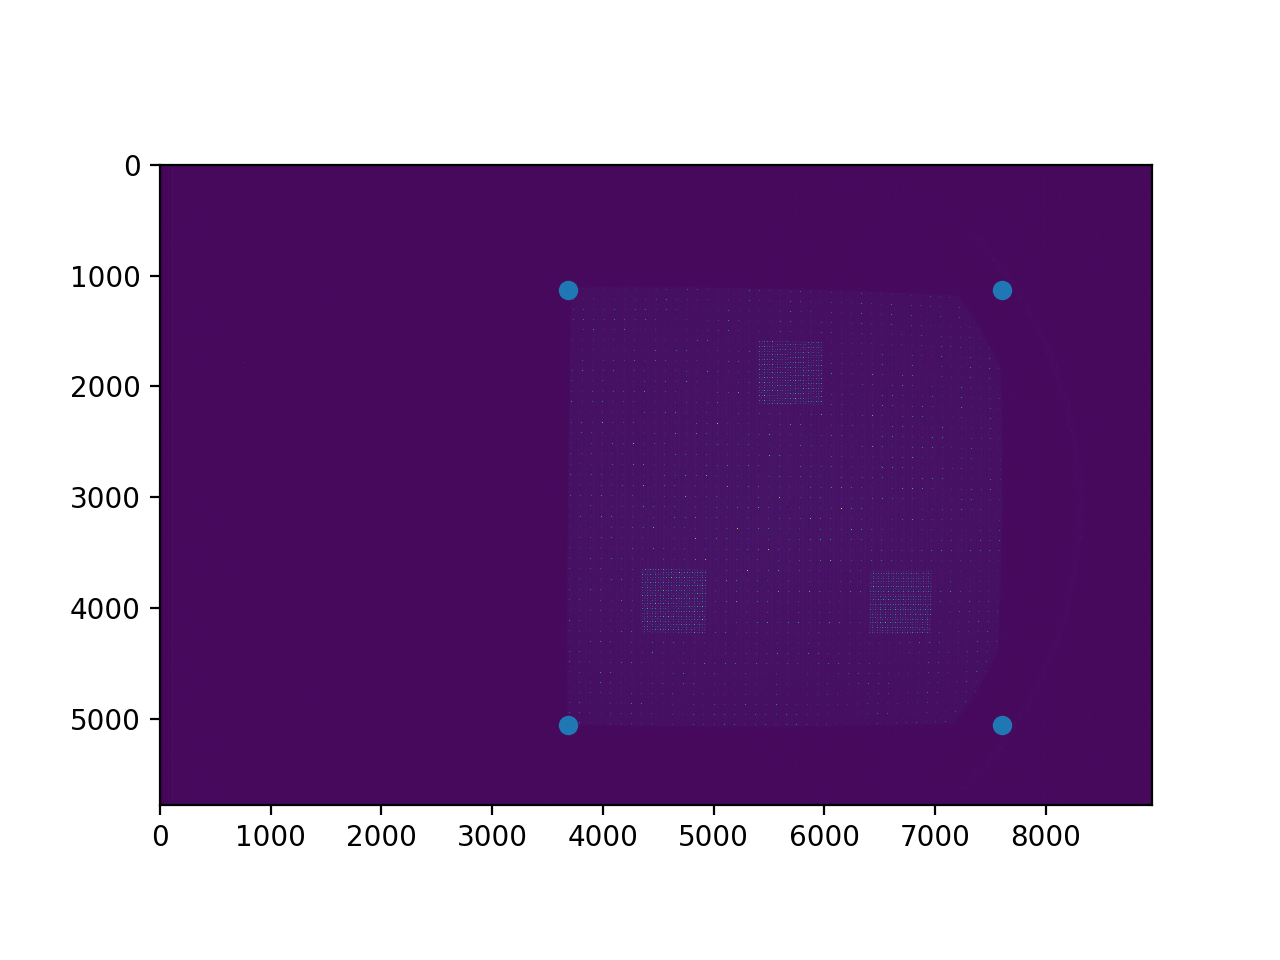

In [27]:
#not needed if pulling from DB
reload(vis)
reload(mcs)
config='calib'

if((cenFlag=='local')):
    
    #if config is not known, find the region (must be rotate by multiple of 90 degrees)
    if(config=='calib'):
        image=vis.getImage(files[0])
        xrange,yrange=mcs.getRegion(image,4,2)
        thresh1,thresh2,xrange,yrange=mcs.getThresh(image,xrange,yrange,sigma1,sigma2)
        
    #if config is known, calculate the region for the threshold from the coord transforms
    else:
        xrange,yrange=mcs.getAutoThresh(image,4,2,rotCent,offset)
        

    print("Thresholds=",thresh1,thresh2)
    print("Boundaries of region (x1,x2,y1,y2): ",xrange[0],xrange[1],yrange[0],yrange[1])

    fig,ax=plt.subplots()
    ax.imshow(image)
    ax.scatter([yrange[0],yrange[0],yrange[1],yrange[1]],[xrange[0],xrange[1],xrange[0],xrange[1]])
    fig.show()


# Do the centroiding for a set of data, either locally or retrieve from DB


In [45]:
reload(vis)

#set redo=1 to recalculate values, redo=0 to read from files    
redo=1

#local case - either read files and calculate, or load data from a file. 
if(cenFlag=="local"):

    boxfind=10
    if(redo==1):
        print("Centroiding with Parameters: ",thresh1,thresh2,fwhmx,fwhmy,boxFind,boxCent,nmin,nmax,maxIt)
        xfirst,xlast=vis.getAllCentroids(files,centroidFile,thresh1,thresh2,fwhmx,fwhmy,boxFind,boxCent,nmin,nmax,maxIt)
        centroids=np.loadtxt(centroidFile)
    else:
        print("Loading Centroids from File.")
        centroids=np.loadtxt(centroidFile)
#db case - read from database
elif(cenFlag=='db'):
    printf("Loading Centroids from DB.")
    centroids=vis.getCentroidsDB(conn,frameIDs)        
        
#extract the first set of centroids for summary plot, and for referencing points later
ind=np.where(centroids[:,0]==0)
xfirst=centroids[ind,1].ravel()
yfirst=centroids[ind,2].ravel()
         
#vis.checkCentroids(xfirst,yfirst,1,prefix,inter)


Centroiding with Parameters:  1843.855619174775 1142.6118278292856 0 0 10 6 10 90 20
11 Frames. Centroiding 1: 3539, 2: 3540, 3: 3541, 4: 3542, 5: 3539, 6: 3542, 7: 3541, 8: 3539, 9: 3536, 10: 3540, 11: 3540, 


In [51]:
reload(vis)

#match all the frames to the first frame
tol=20
xArray,yArray,fxArray,fyArray,backArray,peakArray,qualArray=vis.matchAllPoints(centroids,xfirst,yfirst,tol)
    
#get transformations by frame
xdAll,ydAll,sxAll,syAll,rotAll,fxFrameAv,fyFrameAv,peakFrameAv,transAll = vis.getTransByFrame(xArray,yArray,fxArray,fyArray,peakArray,xfirst,yfirst)

#sAll=(sxAll+syAll)/2
xAv,yAv,fxAv,fyAv,peakAv,backAv,rmsVal,nMatch,xArray1,yArray1,dd,rmsX,rmsY,xd,yd = vis.getRMSStats(xArray,yArray,fxArray,fyArray,peakArray,backArray,xdAll,ydAll,sxAll,syAll,rotAll,xfirst,yfirst)



10 frames. Matching 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
Translating 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 


/Users/karr/Science/PFS/NewCode/Code/visRoutines.py:571: RuntimeWarning: invalid value encountered in sqrt
  dd[i,:]=np.sqrt((xArray1[i,:]-xm[i])**2+(yArray1[i,:]-ym[i])**2)
/Users/karr/Science/PFS/NewCode/Code/visRoutines.py:572: RuntimeWarning: invalid value encountered in sqrt
  xd[i,:]=np.sqrt((xArray1[i,:]-xm[i])**2)
/Users/karr/Science/PFS/NewCode/Code/visRoutines.py:573: RuntimeWarning: invalid value encountered in sqrt
  yd[i,:]=np.sqrt((yArray1[i,:]-ym[i])**2)



# Image Quality Plots

Now we get into the analysis part. 

Plots of FWHM values, peak values, and a rough calculation of total flux.  Set plotrange to the range you want for the colour bar (2 element numpy array); the default is min and max. 


# Distortion Plots

Calculations and plots for distortion of a single field. The results are plotted in three forms; quiver, colour map in mm units, colour map in units of % of the field size. 


In [38]:
print(xAv.shape,fxArray.shape,xfirst.shape)

NameError: name 'xAv' is not defined

<IPython.core.display.Javascript object>


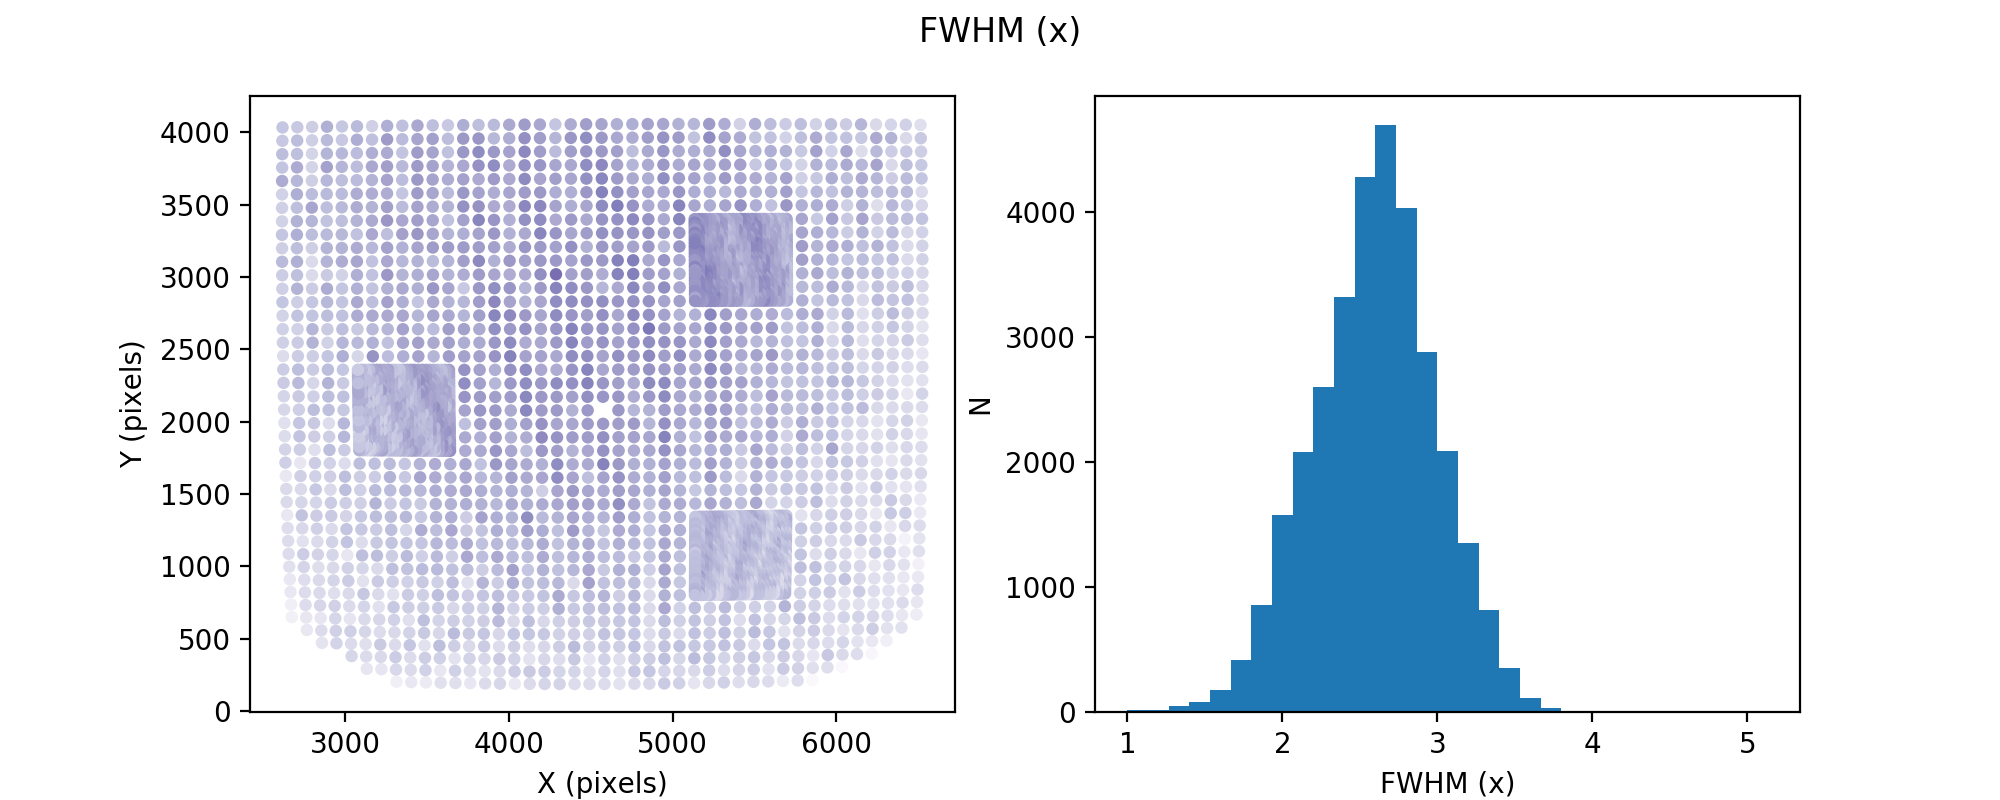

<IPython.core.display.Javascript object>


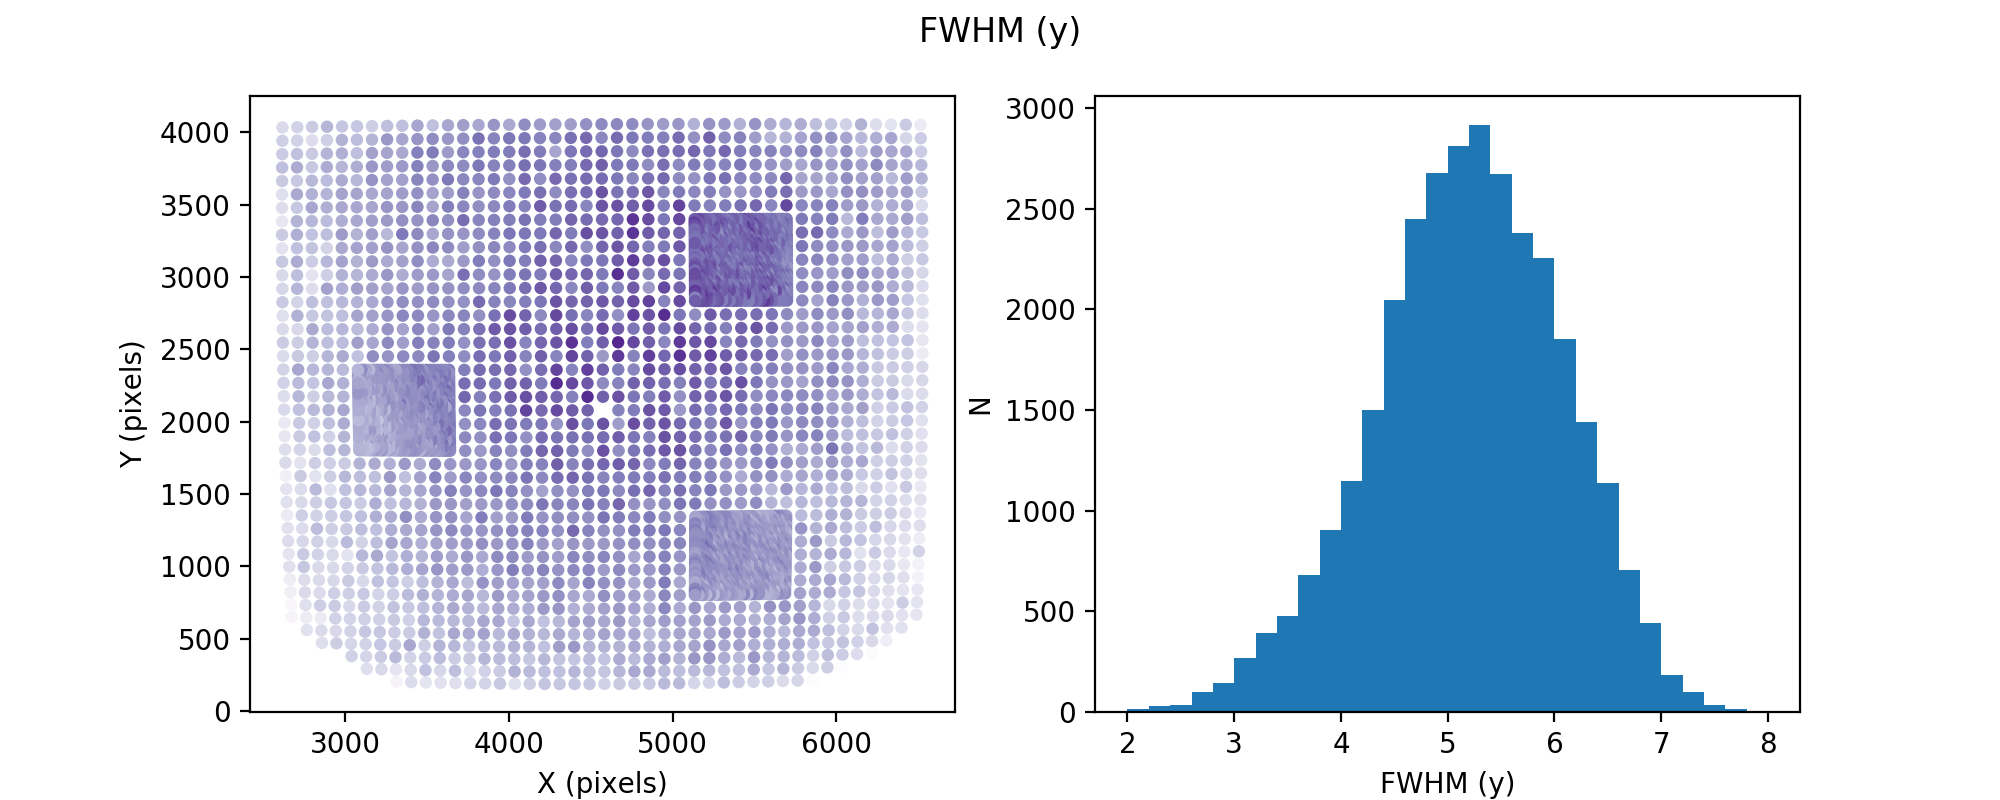

<IPython.core.display.Javascript object>


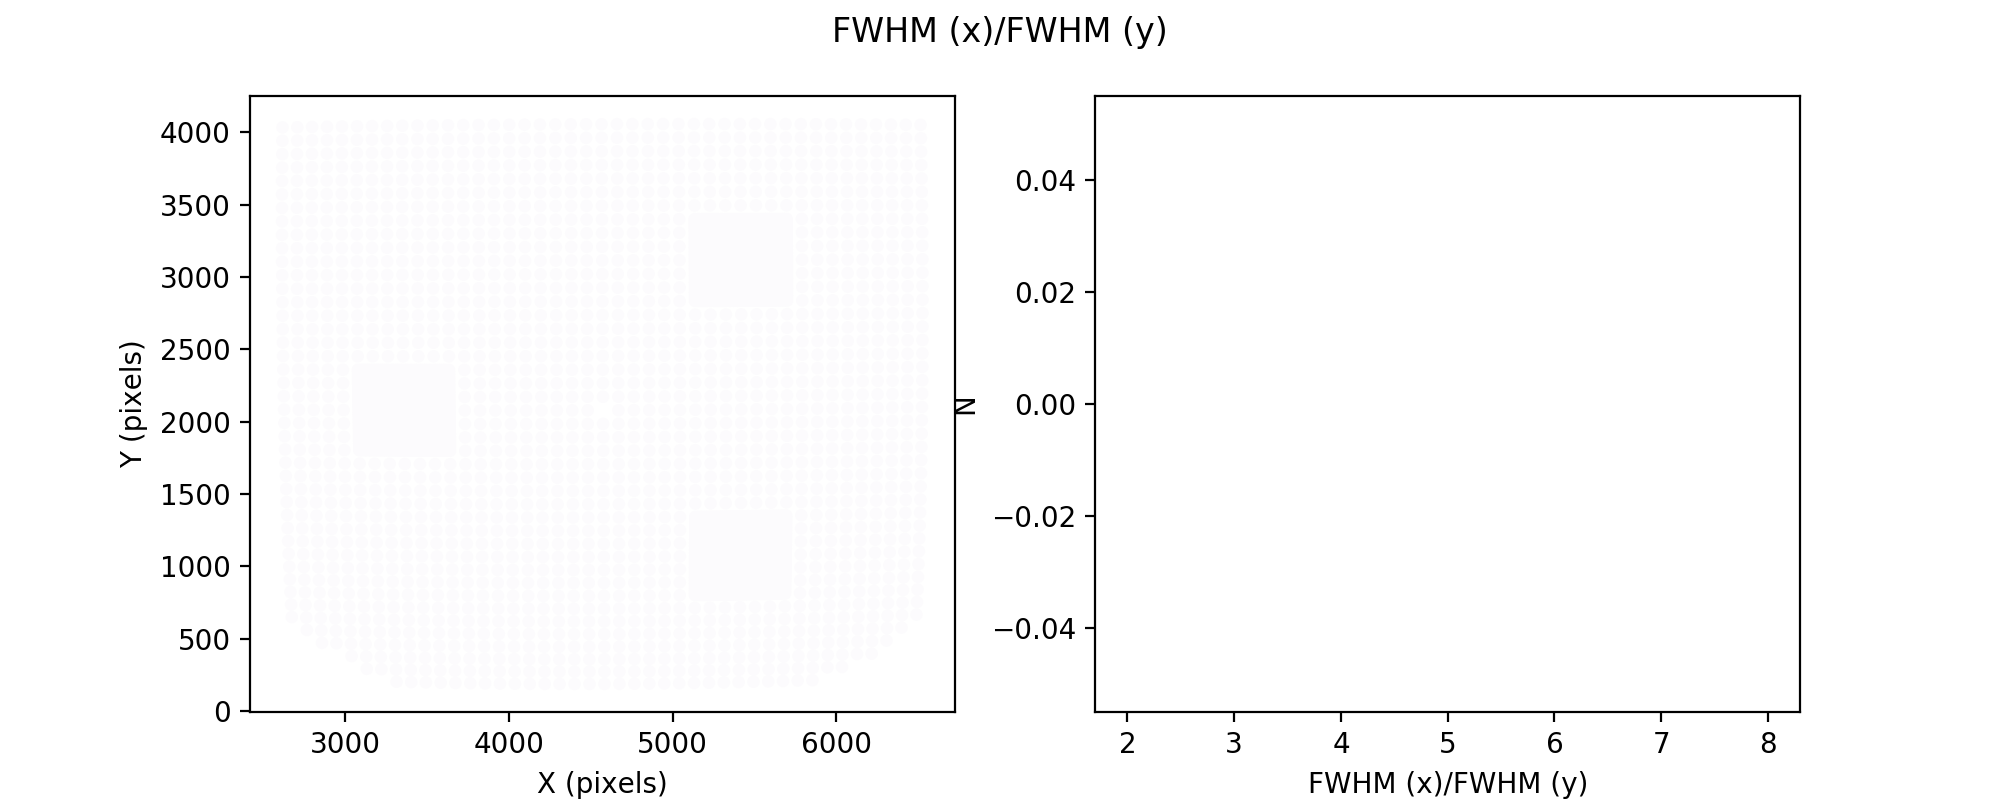

In [84]:
reload(visplot)

plotRange=None
nbins=30

plotRange=[1,5]
visplot.pairPlot(xfirst,yfirst,fxAv,fxArray.ravel(),plotRange,"FWHM (x)",prefix,"_fwhmx","FWHM (x)","pixels",nbins,inter,stitle=stitle)
plotRange=[2,8]
visplot.pairPlot(xfirst,yfirst,fyAv,fyArray.ravel(),plotRange,"FWHM (y)",prefix,"_fwhmy","FWHM (y)","pixels",nbins,inter,stitle=stitle)
plotrange=[0.5,2]
visplot.pairPlot(xfirst,yfirst,fxAv/fyAv,(fxArray/fyArray).ravel(),plotRange,"FWHM (x)/FWHM (y)",prefix,"_fwhmxy","FWHM (x)/FWHM (y)","pixels",nbins,inter,stitle=stitle)



<IPython.core.display.Javascript object>


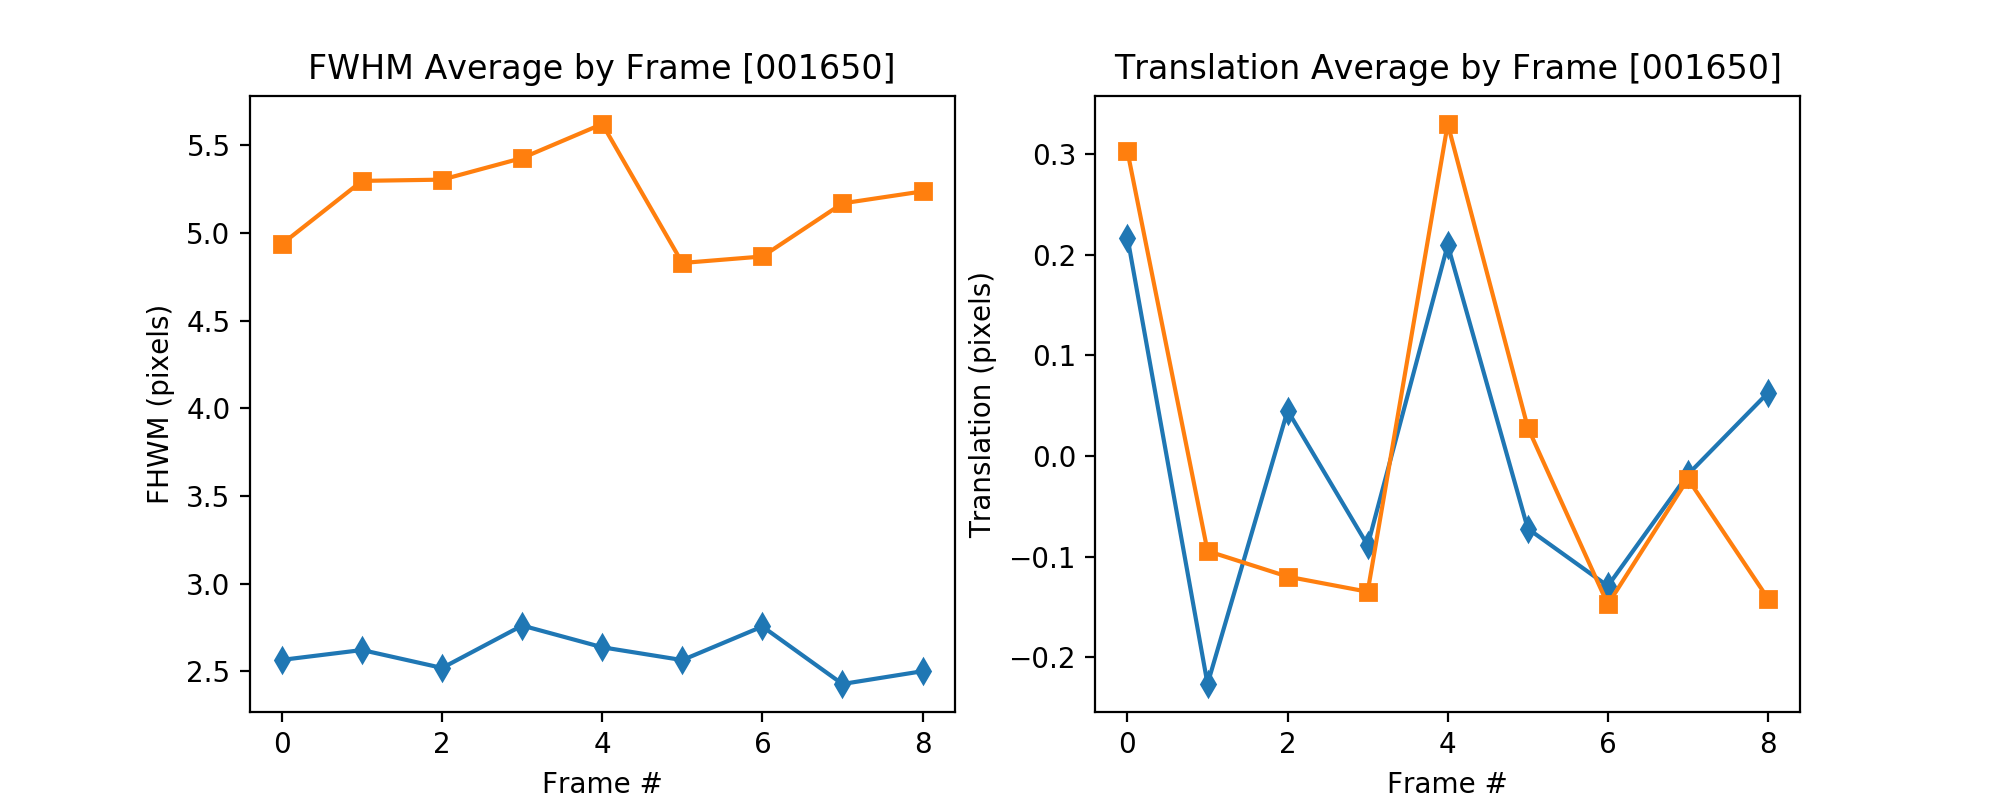

<IPython.core.display.Javascript object>


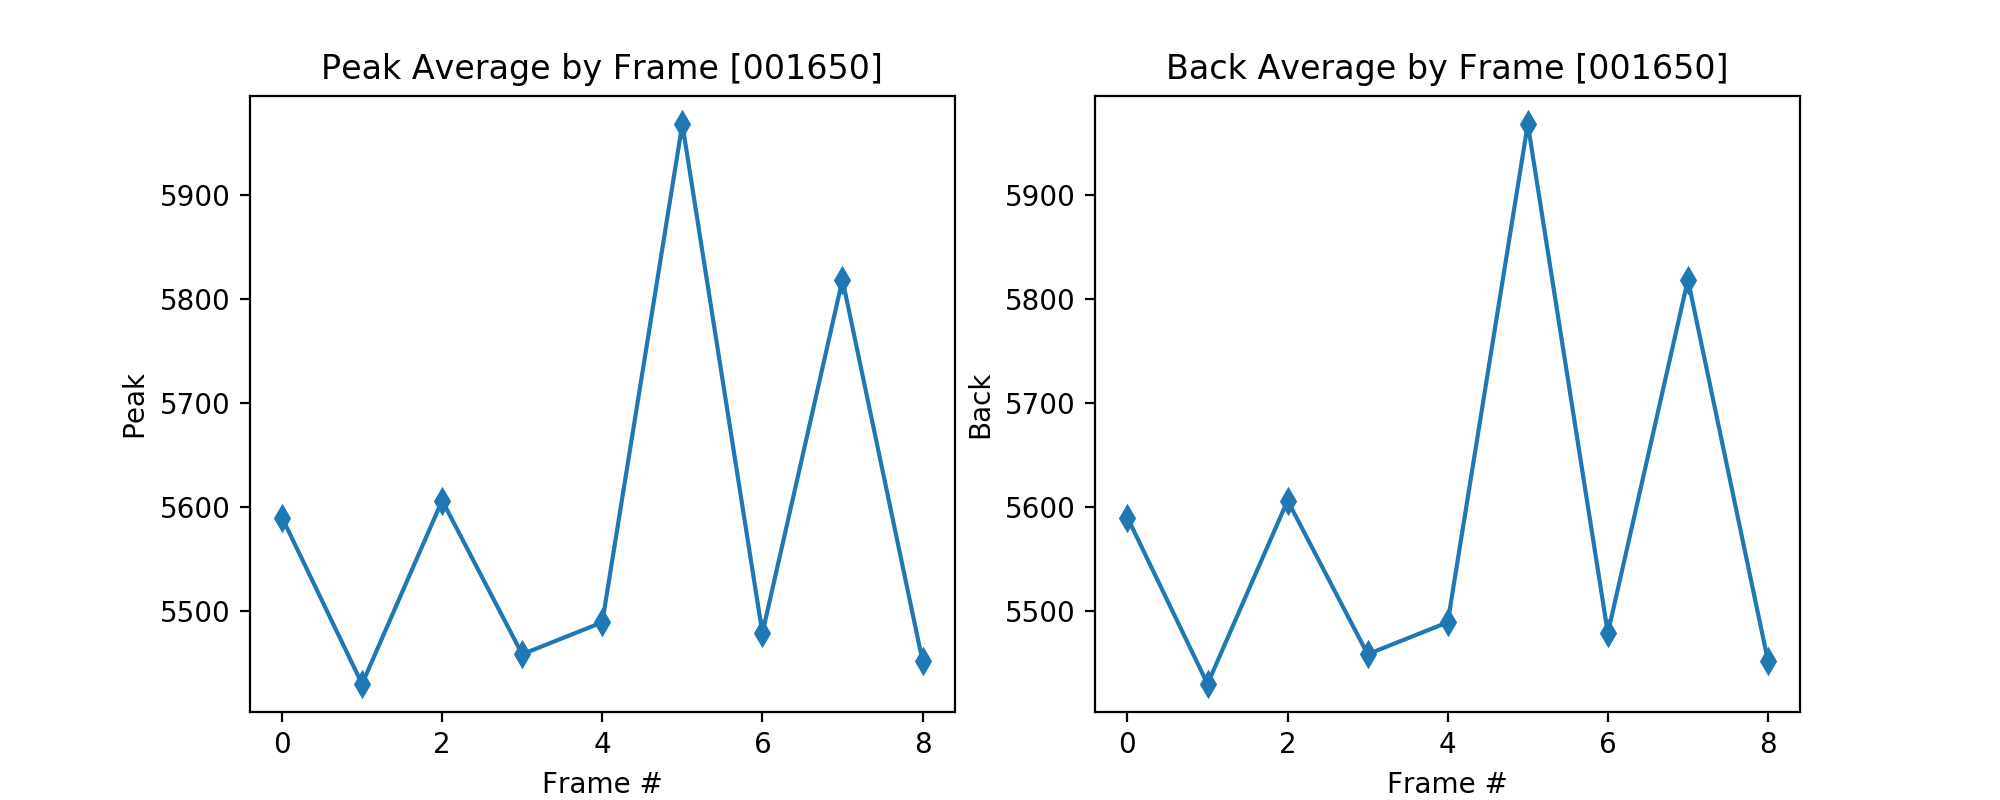

<IPython.core.display.Javascript object>


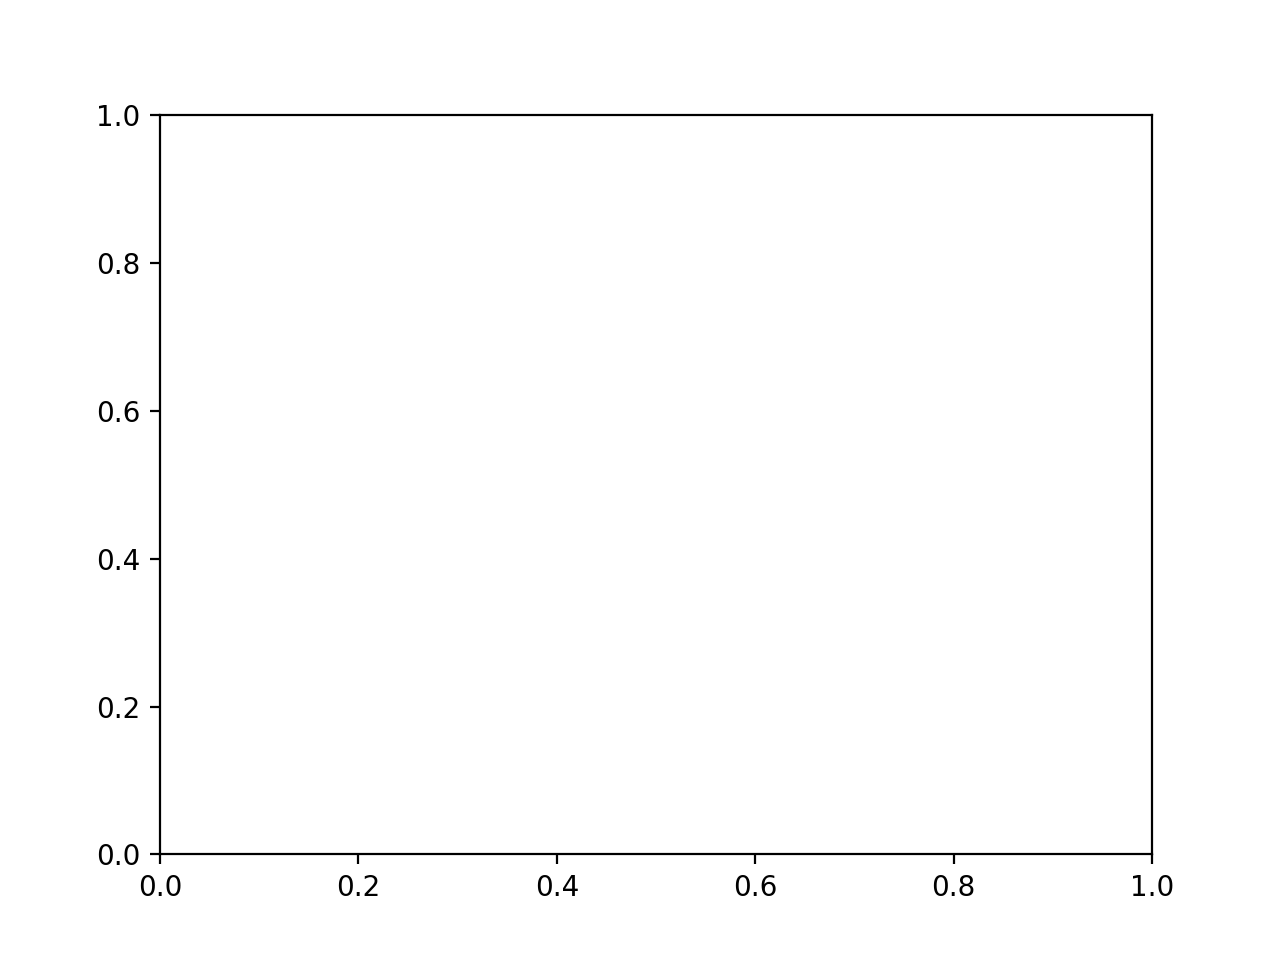

<IPython.core.display.Javascript object>


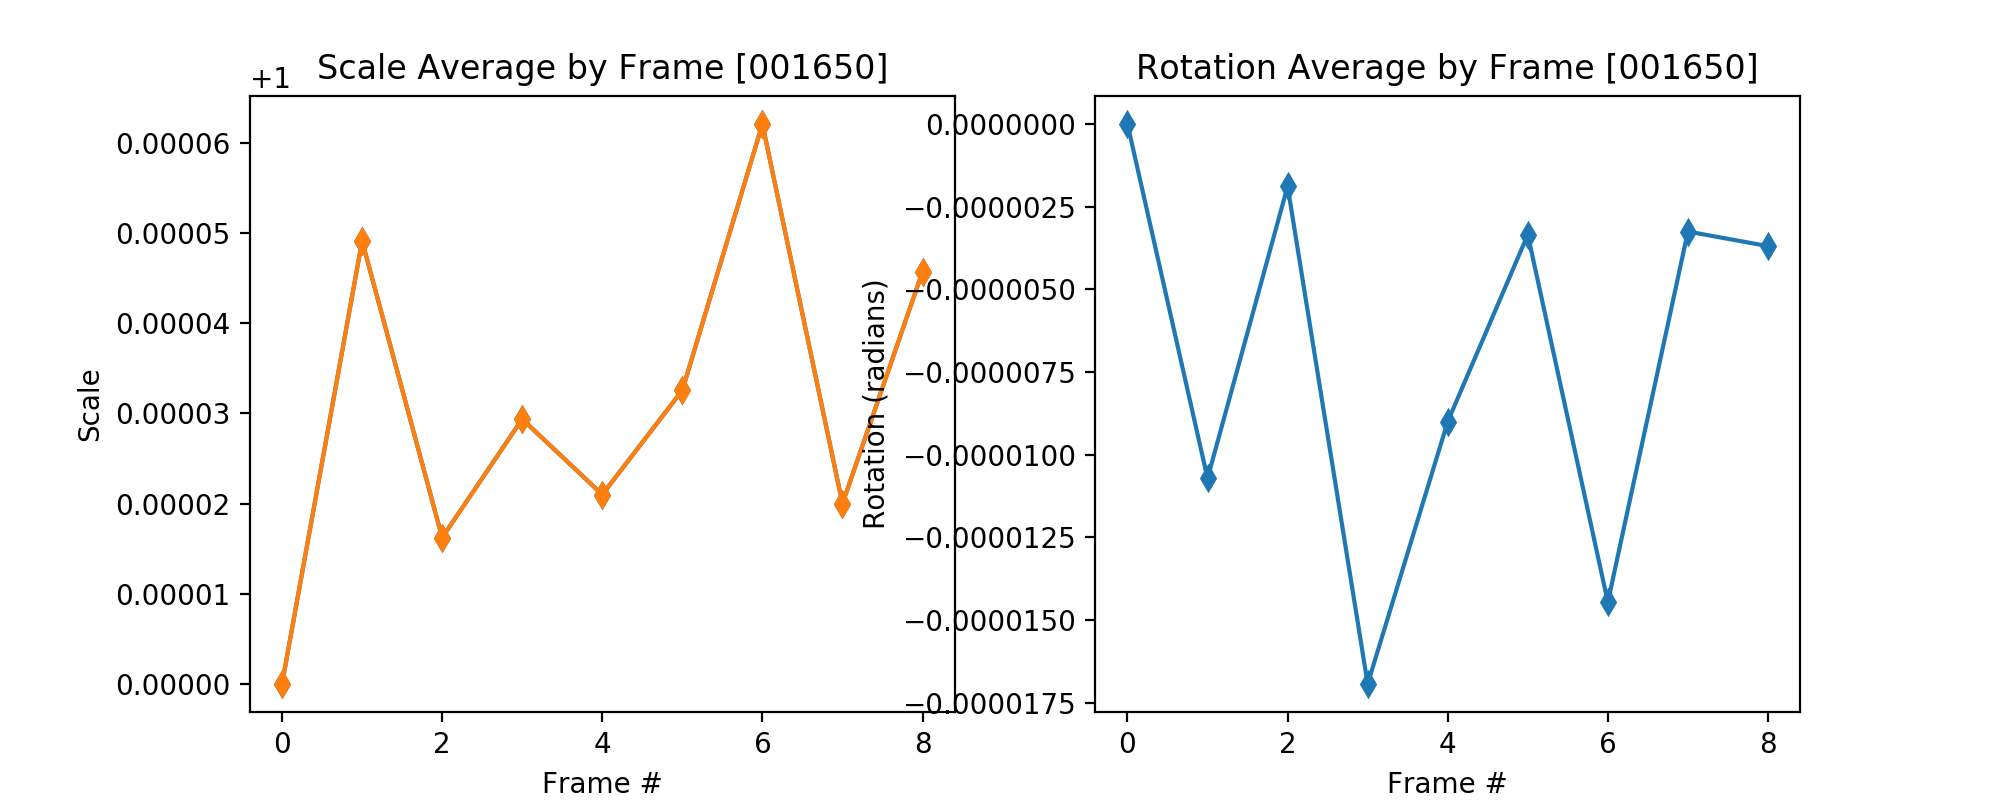

In [89]:

reload(visplot)
visplot.plotTransByFrame(fxFrameAv,fyFrameAv,peakFrameAv,sxAll,syAll,xdAll,ydAll,rotAll,prefix,inter,stitle=stitle)


# Data IO

This writes the calculated variables to a yaml file for later use. The file name is set by the frame ID and an incremental integer (so that old versions are not overwritten). 

The routine creates a dictionary which is dumpted to file, and can be read back in. 


In [115]:
print(sigma1,sigma2)

60 15


In [120]:
xfirst

array([7587.10993443, 7587.34773756, 7586.68411224, ..., 3697.86329137,
       3697.90139736, 3698.25948246])

In [121]:
yfirst

array([2839.4174094 , 2747.83765364, 2931.08192975, ..., 4390.23913137,
       4297.34260765, 4110.99470846])

In [122]:
xfirst.shape

(4298,)

In [134]:
for i in range(len(xfirst)):
    dd=np.sqrt((xfirst[i]-xfirst)**2+(yfirst[i]-yfirst)**2)
    ind=np.where(dd > 0)
    #print(dd[ind].min())
    if(dd[ind].min() < 1):
        print(xfirst[i],yfirst[i],dd[ind].min())


7327.33097122615 3111.864974033336 0.0010263123805510674
7327.331105777441 3111.863956579134 0.0010263123805510674
7055.258003568716 3665.4417356389654 0.031101700979589825
7055.227818105715 3665.434242066569 0.031101700979589825
6976.455865116195 2829.5564324916254 0.003418174853349456
6975.2032814251215 3015.3883704726345 0.020951710860599427
6968.072417862723 3572.859256351198 0.012838436901447356
6976.45476345011 2829.5531967148772 0.003418174853349456
6975.182460036272 3015.386037244325 0.020951710860599427
6960.209672876625 3942.782009042919 0.053505822239760026
6968.059663958856 3572.857785501713 0.012838436901447356
6960.175990801133 3942.7404351231603 0.053505822239760026
6944.040825048788 3665.5065826904756 0.02054484530015615
6943.063661259364 3711.7785799158723 0.00969996488047015
6936.260961361861 4012.070933680357 0.028937734828491664
6944.021134381933 3665.5007202415673 0.02054484530015615
6943.053989821491 3711.777836539692 0.00969996488047015
6936.232170211444 4012.068

6553.268137626862 4037.087413009871 0.025741449150426813
6552.647938321649 4060.221117112325 0.00011764525526720137
6551.4755436817995 4106.508950417254 0.003296156708336149
6537.146624991949 3711.736134319691 0.017449326970987628
6537.5468194333735 3688.4722565840725 0.0037592375382912717
6536.259905810602 3758.3754754605443 0.025282384044242885
6535.287521652632 3804.90302091759 0.01964854582549715
6537.129267188945 3711.7343494705005 0.017449326970987628
6537.548743340681 3688.469026963732 0.0037592375382912717
6528.145952353064 4129.74932261314 0.020773398185429278
6536.234768823793 3758.3727679086687 0.025282384044242885
6527.042340852429 4175.951450106514 0.007953717625484729
6535.268051369421 3804.9003801933027 0.01964854582549715
6524.0939742197925 2916.685304297163 0.009089741053377788
6523.501529712321 3010.3149406357 2.4653167690134598e-05
6528.125310008561 4129.746992873753 0.020773398185429278
6520.519013301342 3291.1729455306177 1.806189471969991e-05
6527.034457220942 417

6048.169369947499 4037.7071525716665 0.0229547160416939
5971.935082279729 2627.7543467805267 0.00017357102226897022
5972.345800452425 2533.835468838316 0.005308472607310062
5971.45161657167 2721.7477883819793 0.0015439112721886824
5969.4453560455095 3004.2215558502694 0.0021553648582204347
5968.422970935495 3098.4458855804587 0.0304355522849115
5967.542231427386 3192.6403643796725 0.00212596373425933
5966.400871126433 3286.862202033854 0.0008546789066490515
5965.1998682170315 3380.9512321950438 0.01912046360023054
5964.003995782099 3475.034331680681 0.007975994254300497
5971.934979563401 2627.7542068653534 0.00017357102226897022
5972.34427426162 2533.8303844875168 0.005308472607310062
5971.451607844658 2721.746244495372 0.0015439112721886824
5961.584127785528 3663.074146832073 3.100354242942236e-05
5969.445760355564 3004.223672954672 0.0021553648582204347
5960.172447488883 3756.9419620202243 0.021973927893241523
5968.393453770207 3098.438465351604 0.0304355522849115
5967.5425343148545 

5597.110281222513 2717.0229116034016 0.01431187504493187
5596.363088159237 2811.341354956653 0.00018625983451833918
5594.989001668692 3000.2703814908214 0.00016271244331749068
5595.66828962852 2905.7211358320683 0.00025951101194169246
5593.252627206571 3189.227859035168 0.017739735209118423
5592.107544415287 3283.6516776145677 0.009751775780970674
5600.0235985637755 2246.5302843661448 0.00988367352882008
5600.503745916961 2152.959083192842 0.0006203871896727462
5600.557073872558 2129.500076827513 3.061165406092609e-06
5600.728032468306 2106.146594512686 1.4785665489696601e-06
5590.986299769989 3378.0936777065294 0.00022473045144610587
5599.156425276462 2434.446568962004 0.018241050471307
5599.677382778487 2340.5011043495842 2.7620394522296803e-05
5597.795744324882 2622.7634536419673 0.0012303717079902785
5598.493424334585 2528.5410138396346 2.9069268129314184e-05
5597.096086742819 2717.0210822555564 0.01431187504493187
5588.580676182289 3566.7206289250275 0.0019557448429723475
5596.362

5110.765153995857 4127.720494599653 0.0003929266221296222
5112.012482201255 4033.9279504343604 0.004823476421750042
5119.548479635583 3373.969814581918 0.0001037980238105542
5118.4931956454075 3468.567955391751 0.0026225947648628057
5116.321583258717 3657.5278351208212 0.003525401615161316
5115.3744218916245 3751.840302103491 0.024943390213900817
5114.366837895094 3845.9980416306826 0.02969074448507236
5113.305428581568 3940.0902619661665 0.02648968189570289
5110.764817793357 4127.720291230015 0.0003929266221296222
5112.007747056779 4033.9270315591853 0.004823476421750042
5039.348545916807 1678.542947959475 0.0260034323359118
5032.275886110897 2616.119099356396 0.000646229629461031
5033.120839950829 2521.5949941336685 0.010996403423654223
5031.315523798268 2710.5427530875895 0.021299882404089546
5039.323020266897 1678.5379861362267 0.0260034323359118
5030.459091192157 2805.159026904872 0.0028910832196737814
5029.582130207138 2899.728072695469 0.0019328358432097385
5028.6185783529145 29

4830.267114114919 3890.585748322774 0.02813427304917358
4827.890354934309 4101.974193086294 0.00019803114785520092
4828.10936940313 4078.5350401658147 0.01255062321978705
4828.291922438434 4055.052187233933 0.00021437890970295753
4828.500451628798 4031.5979797677746 0.009043067298419265
4827.118748589391 4195.644928737846 0.009733150860126221
4827.339650621685 4172.273977686542 0.00551131389993095
4809.208003650459 3654.7860405576557 0.018540047999533092
4807.9992380010635 3772.7207279841855 0.012478000280426109
4808.223707658247 3749.1547711688727 0.020234511043622533
4808.450175761303 3725.6167645752207 0.03035753955127665
4808.629685223849 3702.004750483802 3.984998370668167e-05
4807.226903682031 3843.454854905428 0.024893117468705185
4807.476745968074 3819.8690444221493 0.03899003657439765
4807.774945256183 3796.314903172578 4.137539204277343e-05
4805.900072590153 3937.508745904408 0.0035308024628489627
4804.024839498767 4125.172444989799 0.00498095117228498
4804.266484900658 4101.

4619.410383944258 3700.147461975689 8.41871861276614e-06
4619.559620490795 3676.5572252803627 0.002728287757796561
4617.556788063903 3912.1751849904836 0.00011317756472065714
4617.677460250521 3888.596970587324 0.002602282850825152
4616.05611368358 4053.080695264648 0.005492004515802423
4616.2093370400025 4029.633335771506 0.020719560305468888
4616.540783057497 4006.17175834397 0.03784480451594148
4616.746747144393 3982.684324467322 0.009552032694671133
4615.142470598581 4146.759597131363 0.01895686129596452
4615.353862032082 4123.366977420897 0.032081584743451574
4615.771966928836 4076.5349148420783 0.04775963404479717
4619.137784191382 3723.6710556634525 0.010288710629643916
4619.410380933704 3700.147454113667 8.41871861276614e-06
4619.559285261263 3676.554517666053 0.002728287757796561
4617.556895158681 3912.175221594713 0.00011317756472065714
4617.6765584987215 3888.594529538425 0.002602282850825152
4616.050668787773 4053.079977474114 0.005492004515802423
4616.1896000167935 4029.62

4383.074138924076 3673.9495077907177 0.005868031823776092
4383.182393284703 3650.39475679663 0.022035220873994635
4382.487223491129 3744.785437553972 0.0016760417092567567
4379.980322835927 4026.9891360159563 0.00019880341076921186
4380.15072534665 4003.4773747808376 0.01616709723939745
4380.5630666778725 3956.5609027500273 0.0032751338580622466
4379.0686480976265 4190.949486266621 0.005347962840277748
4382.773991043446 3697.601191163623 0.003088139839918991
4383.068329408683 3673.948681153925 0.005868031823776092
4383.161343788964 3650.3882399194567 0.022035220873994635
4375.170300905965 2138.5934090993337 0.00786046363768682
4382.487084775409 3744.7837672624523 0.0016760417092567567
4379.980195315579 4026.9889834992127 0.00019880341076921186
4380.135579085843 4003.471720948798 0.01616709723939745
4380.562406225456 3956.5576948995954 0.0032751338580622466
4379.063338974311 4190.948842903458 0.005347962840277748
4368.712751921498 2704.0173736251268 0.0004110203531880325
4367.7144140544

In [41]:
xArray

masked_array(
  data=[[--, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --,

<IPython.core.display.Javascript object>


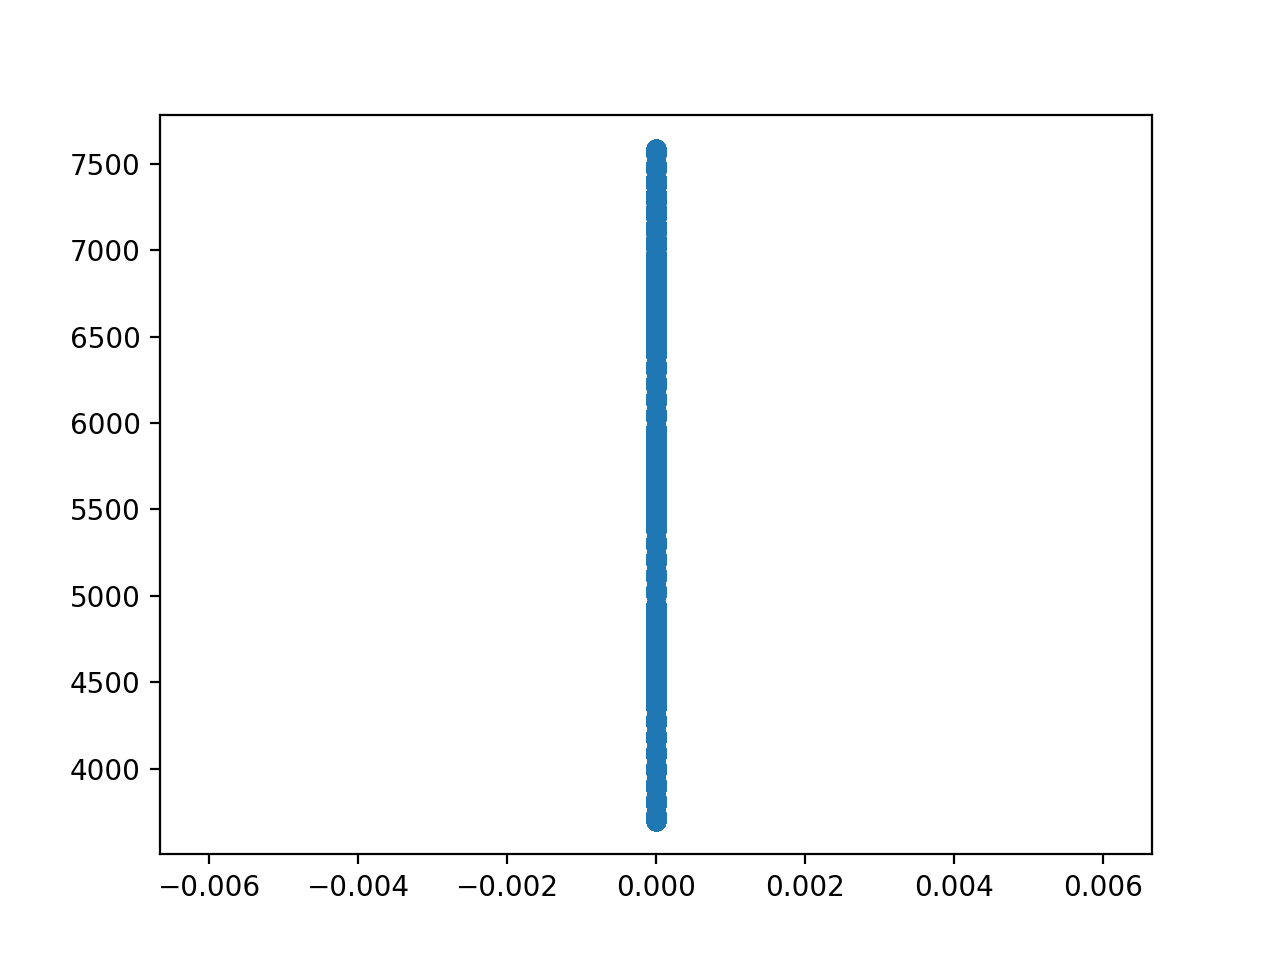

In [44]:
fig,ax=plt.subplots()
ax.scatter(xArray,yArray)
fig.show()